# 20. Principal Component Analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rhennig/EMA6938/blob/main/Notebooks/20.PrincipalComponentAnalysis.ipynb)

(Based on https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)

In this notebook, we will learn about an unsupervised machine learning method for dimensionality reduction, principal component analysis (PCA).

### Introduction

- PCA is an **unsupervised linear dimensionality reduction technique** that can be utilized for extracting information from a high-dimensional space by projecting it into a lower-dimensional sub-space.

- It tries to preserve the essential parts that have more variation of the data and remove the non-essential parts with fewer variation.

- Dimensions are nothing but features that represent the data. For example, the atomic descriptors we used already included the atomic number, atomic and ionic radii, electronegetivity, etc. Each of these descriptor components is a dimension. Note: Features, Dimensions, and Variables are all referring to the same thing. You will find them being used interchangeably.

- You can use PCA to cluster similar data points based on the feature correlation between them.

Definition: PCA is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated numerical variables into a set of values of linearly uncorrelated variables called principal components.

### Five Steps of PCA

Principal component analysis can be broken down into five steps. We will go through each step, explaining what PCA does and discuss the underlying mathematical concepts such as standardization, covariance, eigenvectors and eigenvalues without focusing on how to compute them.

1. Standardize the range of continuous initial variables
2. Compute the covariance matrix to identify correlations
3. Compute the eigenvectors and eigenvalues of the covariance matrix to identify the principal components
4. Create a feature vector to decide which principal components to keep
5. Recast the data along the principal components axes

PCA is easiest to understand and visualize by looking at a two-dimensional dataset.

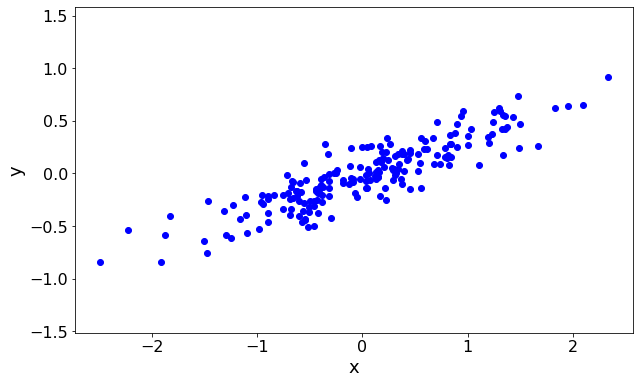

In [1]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T

plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], color='blue')
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.axis('equal');

It is apparent that there is a nearly linear relationship between the $x$ and $y$ variables. This is reminiscent of the linear regression data we explored previously, but the problem setting here is slightly different. Rather than attempting to predict the $y$ values from the $x$ values, the unsupervised learning problem attempts to learn about the relationship between the $x$ and $y$ values.

In principal component analysis, this relationship is quantified by finding a list of the principal axes in the data, and using those axes to describe the dataset.

### Step 1. Standardization

The goal is to standardize the range of the variables so that each one of them contributes equally to the analysis.

PCA, is sensitive to the variances of the initial variables. If there are large differences between the ranges of the different features, those with larger ranges will dominate over those with small ranges.

For example, the $x$ values have a much larger range than the $y$ values. Hence the $x$ values would dominate over the $y$ values, which will lead to biased results. So, transforming the data to comparable scales can prevent this problem.

Mathematically, this can be done by subtracting the mean and dividing by the standard deviation for each value of each variable.
$$
x_\mathrm{standardized} = \frac{x - \mathrm{mean}}{\mathrm{standard\,\,deviation}}
$$

In [2]:
# Standardize each column
X_std = (X - X.mean(axis=0)) / X.std(axis=0, ddof=1)
print(X_std[:5])

[[-0.79765231 -0.52797714]
 [ 1.12257896  1.89258326]
 [-0.76525502 -1.26763379]
 [-2.73817694 -1.68109939]
 [-0.59924629 -1.57387245]]


In [3]:
# Alternatively, we can use the sklearn's StandardScaler
# The results are slighly different because sklearn
# uses a normalization of N and not N-1 for the standard deviation.
# We can use the same normalization above, if we pass the parameter ddof=0 to std()
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
scaler.transform(X)[:5]

array([[-0.79965395, -0.52930205],
       [ 1.12539597,  1.89733254],
       [-0.76717536, -1.27081481],
       [-2.74504816, -1.68531797],
       [-0.60075004, -1.57782195]])

### Step 2. Calculation of the Covariance Matrix

The covariance matrix determines if pairs of the input variables are correlated. The covariance matrix is a $p \times p$ symmetric matrix (where $p$ is the number of dimensions). The entries are the covariances associated with all possible pairs of the initial variables. For example, for a 3-dimensional data set with 3 variables $x$, $y$, and $z$, the covariance matrix is a 3×3 matrix of this from:
$$
\begin{bmatrix}
   \mathrm{Cov}(x,x) & \mathrm{Cov}(x,y) & \mathrm{Cov}(x,z) \\
   \mathrm{Cov}(y,x) & \mathrm{Cov}(y,y) & \mathrm{Cov}(y,z) \\
   \mathrm{Cov}(z,x) & \mathrm{Cov}(z,y) & \mathrm{Cov}(z,z) \\
\end{bmatrix}
$$

In [4]:
# Calculate the covariance matrix
mean_vec = np.mean(X_std, axis=0)
Covariance = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %Covariance)

# Alternatively, we can use the numpy function cov
print('\nCovariance matrix using numpy.cov\n%s' %np.cov(X_std.T))

Covariance matrix 
[[1.         0.88938995]
 [0.88938995 1.        ]]

Covariance matrix using numpy.cov
[[1.         0.88938995]
 [0.88938995 1.        ]]


Since the covariance of a variable with itself is its variance (Cov(a,a)=Var(a)), in the main diagonal (Top left to bottom right) we actually have the variances of each initial variable. And since the covariance is commutative (Cov(a,b)=Cov(b,a)), the entries of the covariance matrix are symmetric with respect to the main diagonal, which means that the upper and the lower triangular portions are equal:
$$
\begin{bmatrix}
   \mathrm{Var}(x,x) & \mathrm{Cov}(x,y) & \mathrm{Cov}(x,z) \\
   \mathrm{Cov}(x,y) & \mathrm{Var}(y,y) & \mathrm{Cov}(y,z) \\
   \mathrm{Cov}(x,z) & \mathrm{Cov}(y,z) & \mathrm{Var}(z,z) \\
\end{bmatrix}
$$

The sign of the covariance entries determine the correlation:

- If positive: The two variables increase or decrease together (correlated)
- If negative: One increases when the other decreases (inversely correlated)
- If zero: The two variables are uncorrelated

### Step 3. Compute the Eigenvectors and Eigenvalues of the Covariance Matrix

Eigenvectors and eigenvalues are the linear algebra concepts that we need to compute from the covariance matrix in order to determine the principal components of the data.

What do we mean by principal components?

- Principal components are new variables that are constructed as linear combinations or mixtures of the initial variables.
- These combinations are done in such a way that the new variables (i.e., principal components) are uncorrelated and most of the information within the initial variables is squeezed or compressed into the first components.
- So, the idea is 10-dimensional data gives you 10 principal components, but the PCA tries to put maximum possible information in the first component, then maximum remaining information in the second and so on, until having something like shown in the scree plot below.

In [5]:
eigenvalues,eigenvectors = np.linalg.eig(Covariance)
print(eigenvalues)
print(eigenvectors)

[1.88938995 0.11061005]
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


[0.94469498 1.        ]


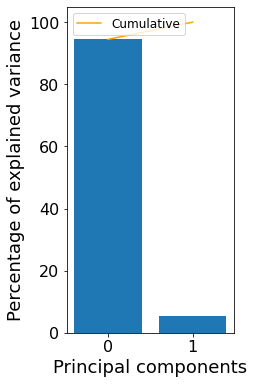

In [6]:
# Calculating the explained variance on each of components

variance_explained = np.cumsum(eigenvalues)/np.sum(eigenvalues)
        
print(variance_explained)

plt.figure(figsize=(3, 6))
plt.bar(np.arange(len(eigenvalues)),100*eigenvalues/np.sum(eigenvalues))
plt.plot(100*variance_explained, color='orange', label='Cumulative')
plt.xlabel('Principal components', fontsize=18)
plt.ylabel('Percentage of explained variance', fontsize=18)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.legend(fontsize=12)
plt.show()

### How PCA Constructs the Principal Components

There are as many principal components as there are variables in the data. Principal components are constructed in such a manner that the first principal component accounts for the **largest possible variance** in the data set.

For our simple 2D dataset, can we guess the first principal component.  It is a line going from the lower left to the upper right. It matches the blue marks because it goes through the origin and it’s the line in which the projection of the points (red dots) is the most spread out. Or mathematically speaking, it’s the line that maximizes the variance (the average of the squared distances from the projected points (red dots) to the origin).

### Step 5. Create a Feature Vector

We need to decide which principal components to keep.

Computing the eigenvectors and ordering them by their eigenvalues in descending order, allow us to find the principal components in order of significance. In this step, what we do is, to choose whether to keep all these components or discard those of lesser significance (of low eigenvalues), and form with the remaining ones a matrix of vectors that we call **feature vector**.

So, the feature vector is simply a matrix that has as columns the eigenvectors of the components that we decide to keep. This makes it the first step towards dimensionality reduction, because if we choose to keep only p eigenvectors (components) out of n, the final data set will have only p dimensions.

In [12]:
feature_vectors = (eigenvectors.T[:][:2])
print(feature_vectors)

[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


### Step 5. Recast the data along the principal component axes

In the previous steps, apart from standardization, we did not make any changes to the data. We just selected the principal components and formed the feature vector. The input data set remained always in terms of the original axes (i.e, in terms of the initial variables).

In this last step, we use the feature vector formed from the eigenvectors of the covariance matrix, to reorient the data from the original axes to the ones represented by the principal components (hence the name Principal Components Analysis). This can be done by multiplying the transpose of the original data set by the transpose of the feature vector.
$$
\text{PCA_Dataset = Standardized Original Dataset} \times \text{Feature_vectors}^\mathrm{T}
$$

In [13]:
X_pca = X_std.dot(feature_vectors.T)
print(X_pca[:5])

[[-0.93736157  0.19068914]
 [ 2.13204165  0.54447527]
 [-1.43746946 -0.35523544]
 [-3.12490026  0.7474667 ]
 [-1.536627   -0.68916477]]


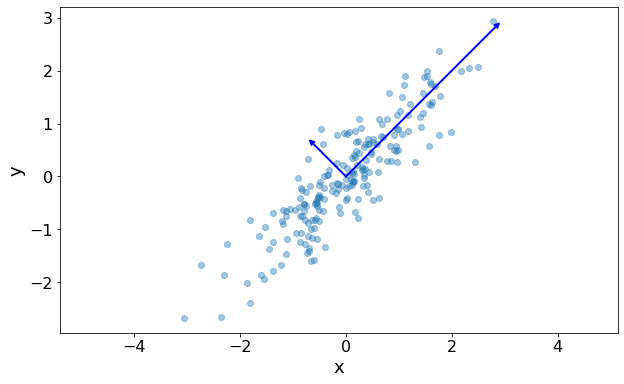

In [14]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color='blue')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.figure(figsize=(10, 6))
plt.scatter(X_std[:, 0], X_std[:, 1], alpha=0.4)
for length, vector in zip(eigenvalues, eigenvectors.T):
    v = vector * 3 * np.sqrt(length)
    draw_vector([0,0], v)
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.axis('equal')
plt.show()

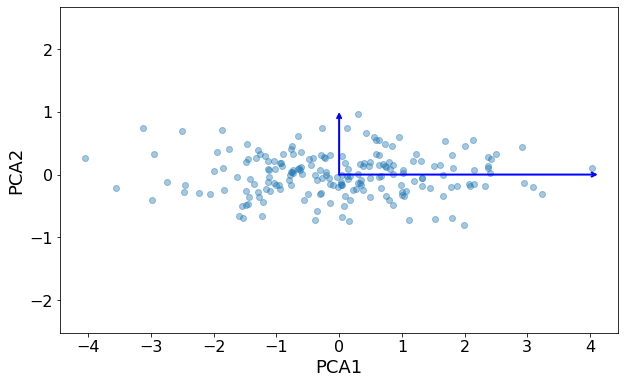

In [15]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color='blue')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.4)
for length, vector in zip(eigenvalues, np.identity(2)):
    v = vector * 3 * np.sqrt(length)
    draw_vector([0,0], v)

plt.xlabel('PCA1', fontsize=18)
plt.ylabel('PCA2', fontsize=18)
plt.axis('equal')
plt.show()